# Recurrent Neural Networks usando Tensorflow

### O presente script implementa uma RNN em TensorFlow para a predição de spam/nao spam em texto.

Começamos carregando as bibliotecas necessárias e inicializando um gráfico de computação no TensorFlow.

In [1]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.python.framework import ops
ops.reset_default_graph()

# Iniciando um gráfico de computação

sess = tf.Session()

### 1. Setando os parâmetros de nossa RNN

In [2]:
# Parâmetros de nossa RNN

epochs = 50
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

### 2. Carregando os dados de treinamento (textos) quanto a SPAM

Nós baixamos e salvamos os dados em seguida. Primeiro, verificamos se já o salvamos antes e carregamos localmente, se não, nós o carregamos da internet (repositório da UCI - http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip).

In [3]:
# Download ou abertura de arquivos referentes a SPAM

data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    
    # Formatando dados
    
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')

    # Salvando dados em arquivo texto
    
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    
    # Recuperando dados de acordo com arquivo texto
    
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]

text_data = [x.split('\t') for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

### 3. Processamento dos textos e criação de representações numéricas (palavras em índices)

In [4]:
# Criando uma função de "limpeza"de texto

def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string


# Textos "limpos"

text_data_train = [clean_text(x) for x in text_data_train]

# Transformando textos em vetores numéricos

vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,
                                                                     min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


### 4. Divisão dos dados em datasets de treino/teste (80/20%)

In [5]:
# Dividindo nossos dados

text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

# Dividindo em datasets de treino/teste 

ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print("Tamanho do vocabulario: {:d}".format(vocab_size))
print("80-20 Divisao em Treino/Teste: {:d} -- {:d}".format(len(y_train), len(y_test)))

Tamanho do vocabulario: 933
80-20 Divisao em Treino/Teste: 4459 -- 1115


## 5. Definição de nosso modelo RNN

Criamos os espaços reservados para os dados, as matrizes de incorporação de palavras (e as pesquisas de incorporação) e definimos o restante do modelo. 

O restante do modelo RNN criará uma célula RNN dinâmica (tipo RNN regular), que variará o número de RNNs necessários para o comprimento de entrada variável (quantidade diferente de palavras para textos de entrada) e, em seguida, será enviada para uma camada logística totalmente conectada tendo em vista prever spam ou nao-spam como saída.

In [6]:
# Criar espaços reservados

x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
y_output = tf.placeholder(tf.int32, [None])

# Criar embedding

embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

# Definir a célula RNN
# tensorflow change> = 1.0, o rnn é colocado no diretório tensorflow.contrib.

if tf.__version__[0] >= '1':
    cell = tf.contrib.rnn.BasicRNNCell(num_units=rnn_size)
else:
    cell = tf.nn.rnn_cell.BasicRNNCell(num_units=rnn_size)

output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

# Obter saída da sequência RNN

output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.matmul(last, weight) + bias

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 6. Declarando a função de perda (entropia cruzada - softmax), uma função de precisão e função de otimização (RMSProp).

In [7]:
# Função de perda

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
loss = tf.reduce_mean(losses)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))

optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

Instructions for updating:
Use tf.cast instead.


C:\Users\vinicius\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Em seguida, inicializamos as variáveis no gráfico computacional.

In [8]:
init = tf.global_variables_initializer()
sess.run(init)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

## 7. Etapa de treinamento

In [9]:
# Iniciando o treinamento

for epoch in range(epochs):

    # "Embaralhando"os dados de treinamento

    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
        
    for i in range(num_batches):
        
        # Selecionando dados de treinamento
        
        min_ix = i * batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        # Executando etapa de treinamento
        
        train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    # Executando perda e acuracia para treinamento
    
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    # Executando etapa de avaliacao (eval. step)
    
    test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    
    print('Epoca: {}, Perda Teste: {:.2}, Acuracia Teste: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))

Epoca: 1, Perda Teste: 0.69, Acuracia Teste: 0.83
Epoca: 2, Perda Teste: 0.66, Acuracia Teste: 0.84
Epoca: 3, Perda Teste: 0.62, Acuracia Teste: 0.83
Epoca: 4, Perda Teste: 0.57, Acuracia Teste: 0.84
Epoca: 5, Perda Teste: 0.52, Acuracia Teste: 0.84
Epoca: 6, Perda Teste: 0.48, Acuracia Teste: 0.84
Epoca: 7, Perda Teste: 0.45, Acuracia Teste: 0.85
Epoca: 8, Perda Teste: 0.42, Acuracia Teste: 0.85
Epoca: 9, Perda Teste: 0.41, Acuracia Teste: 0.85
Epoca: 10, Perda Teste: 0.4, Acuracia Teste: 0.86
Epoca: 11, Perda Teste: 0.39, Acuracia Teste: 0.86
Epoca: 12, Perda Teste: 0.39, Acuracia Teste: 0.87
Epoca: 13, Perda Teste: 0.38, Acuracia Teste: 0.87
Epoca: 14, Perda Teste: 0.38, Acuracia Teste: 0.87
Epoca: 15, Perda Teste: 0.38, Acuracia Teste: 0.87
Epoca: 16, Perda Teste: 0.38, Acuracia Teste: 0.87
Epoca: 17, Perda Teste: 0.37, Acuracia Teste: 0.87
Epoca: 18, Perda Teste: 0.37, Acuracia Teste: 0.87
Epoca: 19, Perda Teste: 0.36, Acuracia Teste: 0.87
Epoca: 20, Perda Teste: 0.35, Acuracia Te

## 7. Plots de perdas e acuracia no tempo (geracoes)

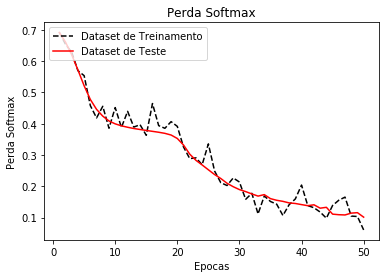

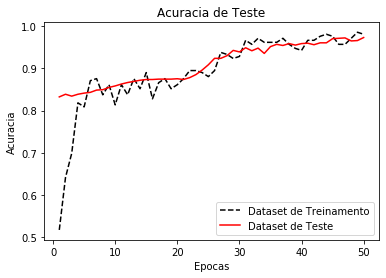

In [10]:
%matplotlib inline

# Plot de perdas no tempo

epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Dataset de Treinamento')
plt.plot(epoch_seq, test_loss, 'r-', label='Dataset de Teste')
plt.title('Perda Softmax')
plt.xlabel('Epocas')
plt.ylabel('Perda Softmax')
plt.legend(loc='upper left')
plt.show()

# Plot ada acuracia no tempo

plt.plot(epoch_seq, train_accuracy, 'k--', label='Dataset de Treinamento')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Dataset de Teste')
plt.title('Acuracia de Teste')
plt.xlabel('Epocas')
plt.ylabel('Acuracia')
plt.legend(loc='lower right')
plt.show()

## 8. Avaliando novos textos (Modifique aqui com textos em inglês de spam/nao spam)

Aqui pode-se utilizar o modelo treinado para avaliar novos textos (que podem ou não ser spam)

In [11]:
sample_texts = ['Hi, please respond 1111 asap to claim your change to win now!',
                'Hey what are you doing for dinner tonight?',
                'New offer, show this text for 50% off of our inagural sale!',
                'Can you take the dog to the vet tomorrow?',
                'Congratulations! You have been randomly selected to receive account credit!']

Limpeza dos textos da amostra.

In [12]:
clean_texts = [clean_text(text) for text in sample_texts]
print(clean_texts)

['hi please respond asap to claim your change to win now', 'hey what are you doing for dinner tonight', 'new offer show this text for off of our inagural sale', 'can you take the dog to the vet tomorrow', 'congratulations you have been randomly selected to receive account credit']


Em seguida, transformamos cada texto como uma seqüência de palavras em uma sequência de índices de vocabulário.

In [13]:
processed_texts = np.array(list(vocab_processor.transform(clean_texts)))
print(processed_texts)

[[ 93  99   0   0   1 114  13 524   1 178  21   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [121  52  20   3 151  12 332 208   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [ 92 376 483  39  69  12 203  15  86   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [ 28   3 104   5   0   1   5   0 143   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]
 [701   3  17  98   0 420   1 318 301 738   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0]]


Agora podemos executar cada um dos textos através do nosso modelo e obter saída.

In [14]:
eval_feed_dict = {x_data: processed_texts, dropout_keep_prob: 1.0}
model_results = sess.run(tf.nn.softmax(logits_out), feed_dict=eval_feed_dict)

print(model_results)

[[0.80929023 0.19070978]
 [0.01161984 0.9883802 ]
 [0.6268035  0.37319648]
 [0.01161727 0.98838276]
 [0.03449769 0.96550226]]


Imprimindo resultados.

In [15]:
categories = ['spam', 'nao spam']

for ix, result in enumerate(model_results):
    prediction = categories[np.argmax(result)]
    
    print('Texto: {}, \nPredicao: {}\n'.format(sample_texts[ix], prediction))

Texto: Hi, please respond 1111 asap to claim your change to win now!, 
Predicao: spam

Texto: Hey what are you doing for dinner tonight?, 
Predicao: nao spam

Texto: New offer, show this text for 50% off of our inagural sale!, 
Predicao: spam

Texto: Can you take the dog to the vet tomorrow?, 
Predicao: nao spam

Texto: Congratulations! You have been randomly selected to receive account credit!, 
Predicao: nao spam

